# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

GPU Ocean-modules:

In [2]:
from gpuocean.ensembles import MultiResOceanStateEnsemble
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
%cuda_context_handler gpu_ctx_refined

## Selecting loc

As initial and boundary conditions to the simulation, we use data from the Norkyst800 s-level files:

In [5]:
nk800_url  = ["/sintef/data/NorKyst800/ocean_his.an.20190716.nc"]

data_args = NetCDFInitialization.removeMetadata(NetCDFInitialization.getInitialConditionsNorKystCases(nk800_url, "lofoten", download_data=False, norkyst_data=False))
data_args.keys()

dict_keys(['nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind'])

In [6]:
data_args["f"]

0.0

In [7]:
sim_args = {
    "dt": 0.0,
    "write_netcdf":False,
    "model_time_step": 60
     }

## Simulation

In [8]:
from gpuocean.SWEsimulators import CDKLM16

sim = CDKLM16.CDKLM16(gpu_ctx, **sim_args, **data_args)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [9]:
sim.step(3600)

3600.0

### Refined Simulation

Defining local area

In [11]:
# [[y0,x0],[y1,x1]]
loc = [[100, 100], [200,300]]

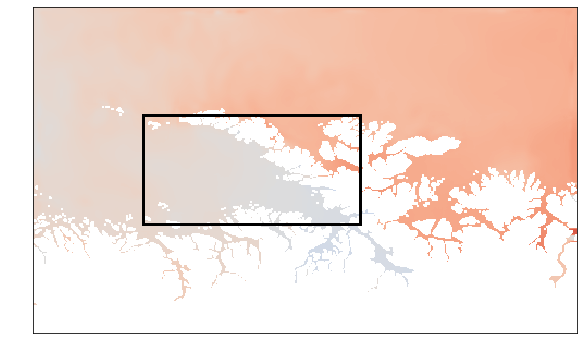

In [12]:
eta, hu, hv = sim.download()

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(eta, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")

import matplotlib.patches as patches
area = patches.Rectangle((loc[0][0], loc[0][1]), loc[1][1]-loc[0][1], loc[1][0]-loc[0][0], edgecolor='black', facecolor='none', lw=3)
ax.add_patch(area)

Extract local IC

In [13]:
sim.give_birth(gpu_ctx_refined, loc, 1.2)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


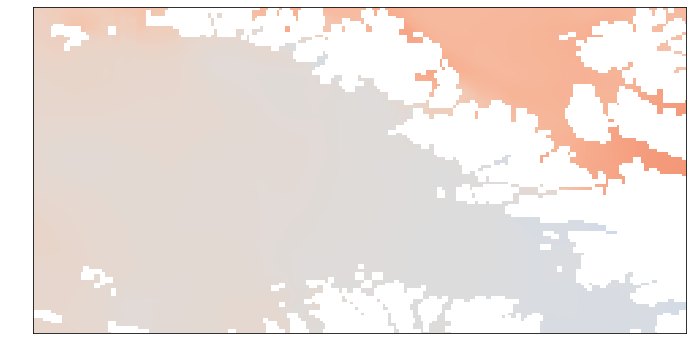

In [14]:
eta, hu, hv = sim.child.download()

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(eta, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")

### Time-Stepping

First model time step

In [38]:
sim.step(3600)

7200.0

In [39]:
eta, hu, hv = sim.download()
eta_refined, hu_refined, hv_refined = sim.child.download()

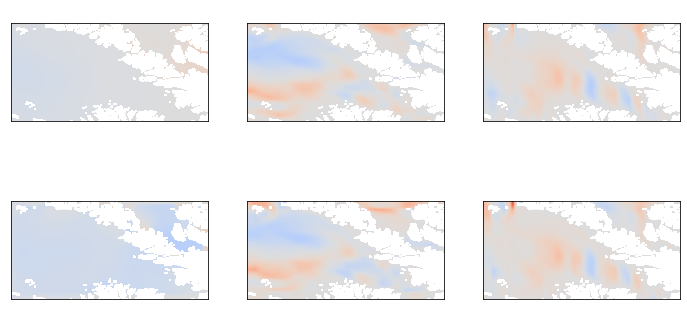

In [40]:
fig, axs = plt.subplots(2,3,figsize=(12,6))

axs[0,0].imshow(eta[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-1, vmax=1, cmap="coolwarm")
axs[0,0].set_title("eta (coarse)")
axs[0,1].imshow(hu[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[0,1].set_title("hu (coarse)")
axs[0,2].imshow(hv[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[0,2].set_title("hv (coarse)")

axs[1,0].imshow(eta_refined, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")
axs[1,0].set_title("eta (refined)")
axs[1,1].imshow(hu_refined, origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[1,1].set_title("hu (refined)")
axs[1,2].imshow(hv_refined, origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[1,2].set_title("hv (refined)")

for ax_s in axs:
    for ax in ax_s:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

### Sampling coarse noise (for reference)

In [41]:
from gpuocean.SWEsimulators import OceanStateNoise
small_scale_model_error = OceanStateNoise.OceanStateNoise.fromsim(sim, interpolation_factor=17)

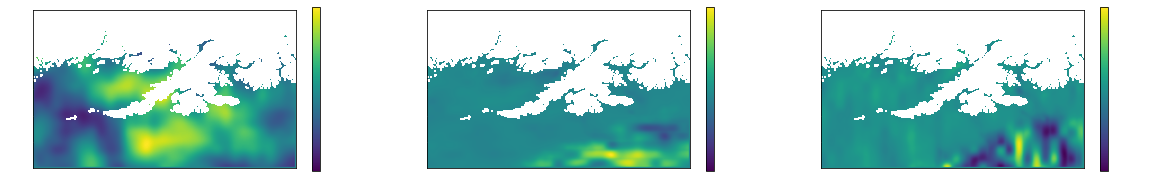

In [42]:
eta_before, hu_before, hv_before = sim.download()
small_scale_model_error.perturbSim(sim)
eta_after, hu_after, hv_after = sim.download()

fig, axs = plt.subplots(1,3, figsize=(20,10))
im = axs[0].imshow((eta_after-eta_before))
plt.colorbar(im, ax=axs[0], shrink=0.3)
im = axs[1].imshow((hu_after-hu_before))
plt.colorbar(im, ax=axs[1], shrink=0.3)
im = axs[2].imshow((hv_after-hv_before))
plt.colorbar(im, ax=axs[2], shrink=0.3)

### Sampling fine noise (reference)

In [45]:
fine_data_args = NetCDFInitialization.removeMetadata(NetCDFInitialization.rescaleInitialConditions(NetCDFInitialization.getInitialConditionsNorKystCases(nk800_url, "lofoten", download_data=False, norkyst_data=False), 1.2))

In [46]:
fine_sim_args = {
    "dt": 0.0,
    "small_scale_perturbation":True,
    "small_scale_perturbation_interpolation_factor":21
     }

In [47]:
fine_sim = CDKLM16.CDKLM16(gpu_ctx, **fine_sim_args, **fine_data_args)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


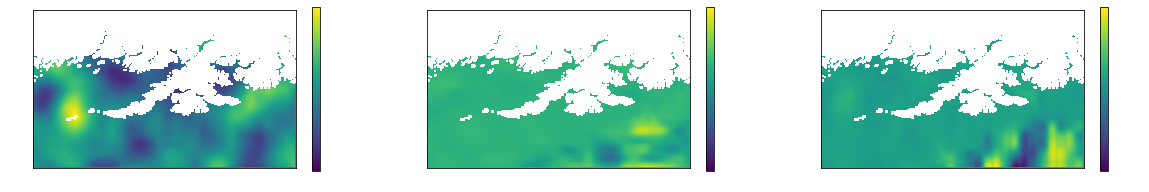

In [48]:
fine_eta_before, fine_hu_before, fine_hv_before = fine_sim.download()
#fine_sim.perturbState()
fine_sim.small_scale_model_error.perturbOceanState(fine_sim.gpu_data.h0, fine_sim.gpu_data.hu0, fine_sim.gpu_data.hv0, fine_sim.bathymetry.Bi, fine_sim.f, ghost_cells_x=2, ghost_cells_y=2)
fine_eta_after, fine_hu_after, fine_hv_after = fine_sim.download()

fig, axs = plt.subplots(1,3, figsize=(20,10))
im = axs[0].imshow((fine_eta_after-fine_eta_before))
plt.colorbar(im, ax=axs[0], shrink=0.3)
im = axs[1].imshow((fine_hu_after-fine_hu_before))
plt.colorbar(im, ax=axs[1], shrink=0.3)
im = axs[2].imshow((fine_hv_after-fine_hv_before))
plt.colorbar(im, ax=axs[2], shrink=0.3)

### Sampling fine noise (with sim)

In [47]:
fine_nx = np.ceil(sim.nx * 1.2).astype(np.int32)
fine_ny = np.ceil(sim.ny * 1.2).astype(np.int32)

fine_dx = sim.child.dx
fine_dy = sim.child.dy

In [48]:
import pycuda.driver as cuda
stream = cuda.Stream()

In [49]:
from gpuocean.utils import Common
eta_pert = Common.CUDAArray2D(stream, fine_nx, fine_ny, 2,2, fine_eta_before)
hu_pert = Common.CUDAArray2D(stream, fine_nx, fine_ny, 2,2, fine_hu_before)
hv_pert = Common.CUDAArray2D(stream, fine_nx, fine_ny, 2,2, fine_hu_before)

In [50]:
fine_sim.small_scale_model_error.perturbOceanState(eta_pert, hu_pert, hv_pert, fine_sim.bathymetry.Bi, 0.0, ghost_cells_x=2, ghost_cells_y=2)

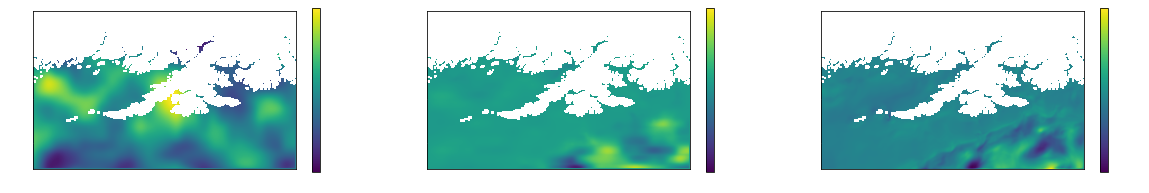

In [51]:
fig, axs = plt.subplots(1,3, figsize=(20,10))
im = axs[0].imshow((eta_pert.data.get()-fine_eta_before))
plt.colorbar(im, ax=axs[0], shrink=0.3)
im = axs[1].imshow((hu_pert.data.get()-fine_hu_before))
plt.colorbar(im, ax=axs[1], shrink=0.3)
im = axs[2].imshow((hv_pert.data.get()-fine_hv_before))
plt.colorbar(im, ax=axs[2], shrink=0.3)

### Sampling fine noise (from zero)

In [52]:
fine_nx = np.ceil(sim.nx * 1.2).astype(np.int32)
fine_ny = np.ceil(sim.ny * 1.2).astype(np.int32)

fine_dx = sim.child.dx
fine_dy = sim.child.dy

In [53]:
import pycuda.driver as cuda
stream = cuda.Stream()

In [54]:
from gpuocean.utils import Common
eta_pert = Common.CUDAArray2D(stream, fine_nx, fine_ny, 2,2, np.zeros_like(fine_eta_before))
hu_pert = Common.CUDAArray2D(stream, fine_nx, fine_ny, 2,2, np.zeros_like(fine_hu_before))
hv_pert = Common.CUDAArray2D(stream, fine_nx, fine_ny, 2,2, np.zeros_like(fine_hu_before))

In [55]:
fine_sim.small_scale_model_error.perturbOceanState(eta_pert, hu_pert, hv_pert, fine_sim.bathymetry.Bi, 0.0, ghost_cells_x=2, ghost_cells_y=2)

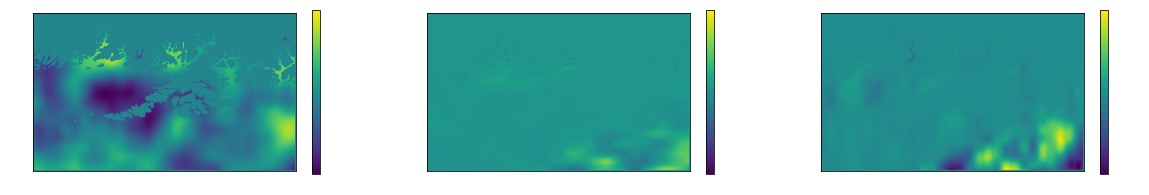

In [56]:
fig, axs = plt.subplots(1,3, figsize=(20,10))
im = axs[0].imshow((eta_pert.data.get()))
plt.colorbar(im, ax=axs[0], shrink=0.3)
im = axs[1].imshow((hu_pert.data.get()))
plt.colorbar(im, ax=axs[1], shrink=0.3)
im = axs[2].imshow((hv_pert.data.get()))
plt.colorbar(im, ax=axs[2], shrink=0.3)

Yuhuuuuuuuuuuuuuuuuu!!!!!!

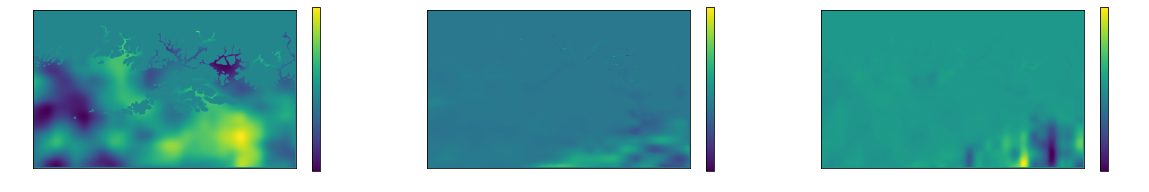

In [73]:
import pycuda.driver as cuda
stream = cuda.Stream()

from gpuocean.SWEsimulators import OceanStateNoise
small_scale_model_error = OceanStateNoise.OceanStateNoise(gpu_ctx, stream, fine_nx, fine_ny, fine_dx, fine_dy, sim.boundary_conditions, staggered=False, interpolation_factor=21, angle= NetCDFInitialization.get_texture(fine_sim, "angle_tex"), coriolis_f=NetCDFInitialization.get_texture(fine_sim, "coriolis_f_tex"))

from gpuocean.utils import Common
eta_pert = Common.CUDAArray2D(stream, fine_nx, fine_ny, 2,2, np.zeros_like(fine_eta_before))
hu_pert = Common.CUDAArray2D(stream, fine_nx, fine_ny, 2,2, np.zeros_like(fine_hu_before))
hv_pert = Common.CUDAArray2D(stream, fine_nx, fine_ny, 2,2, np.zeros_like(fine_hu_before))

small_scale_model_error.perturbOceanState(eta_pert, hu_pert, hv_pert, fine_sim.bathymetry.Bi, 0.0, ghost_cells_x=2, ghost_cells_y=2)

fig, axs = plt.subplots(1,3, figsize=(20,10))
im = axs[0].imshow((eta_pert.data.get()))
plt.colorbar(im, ax=axs[0], shrink=0.3)
im = axs[1].imshow((hu_pert.data.get()))
plt.colorbar(im, ax=axs[1], shrink=0.3)
im = axs[2].imshow((hv_pert.data.get()))
plt.colorbar(im, ax=axs[2], shrink=0.3)

In [65]:
fine_sim.coriolis_texref.get_array()

### Sampling fine noise (with empty sim)

In [15]:
fine_nx = np.ceil(sim.nx * 1.2).astype(np.int32)
fine_ny = np.ceil(sim.ny * 1.2).astype(np.int32)

fine_dx = sim.child.dx
fine_dy = sim.child.dy

In [21]:
pert_data_args = {}
pert_data_args["eta0"] = np.zeros((fine_ny+4,fine_nx+4), dtype=np.float32)
pert_data_args["hu0"] = np.zeros((fine_ny+4,fine_nx+4), dtype=np.float32)
pert_data_args["hv0"] = np.zeros((fine_ny+4,fine_nx+4), dtype=np.float32)
from gpuocean.utils import OceanographicUtilities
pert_data_args["H"] = fine_H = OceanographicUtilities.rescaleIntersections(sim.downloadBathymetry()[0], fine_nx+5, fine_ny+5)[2]
pert_data_args["nx"] = fine_nx
pert_data_args["ny"] = fine_ny
pert_data_args["dx"] = fine_dx
pert_data_args["dy"] = fine_dy
pert_data_args["g"] = sim.g
pert_data_args["r"] = sim.r
pert_data_args["f"] = sim.f

In [23]:
fine_sim_args = {
    "dt": 0.0,
    "small_scale_perturbation":True,
    "small_scale_perturbation_interpolation_factor":21
     }

In [24]:
pert_sim = CDKLM16.CDKLM16(gpu_ctx, **fine_sim_args, **pert_data_args)

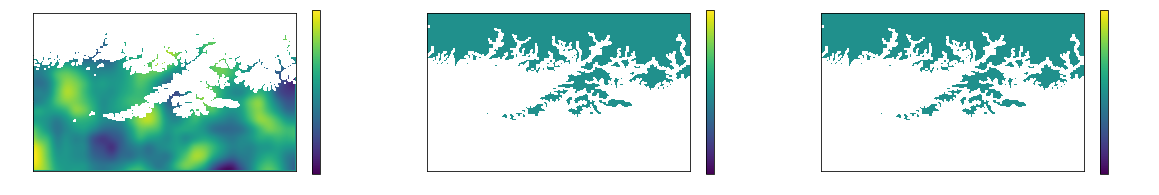

In [25]:
pert_sim.perturbState()
pert_eta_after, pert_hu_after, pert_hv_after = pert_sim.download()

fig, axs = plt.subplots(1,3, figsize=(20,10))
im = axs[0].imshow(pert_eta_after)
plt.colorbar(im, ax=axs[0], shrink=0.3)
im = axs[1].imshow(pert_hu_after)
plt.colorbar(im, ax=axs[1], shrink=0.3)
im = axs[2].imshow(pert_hv_after)
plt.colorbar(im, ax=axs[2], shrink=0.3)

### Sampling fine noise (without sim from zero)

In [61]:
from gpuocean.SWEsimulators import OceanStateNoise
ocean_state_noise = OceanStateNoise.OceanStateNoise(gpu_ctx, stream, fine_nx, fine_ny, fine_dx, fine_dy, sim.boundary_conditions, staggered=False,\
                                                    interpolation_factor=21)

In [62]:
from gpuocean.utils import Common
eta_pert = Common.CUDAArray2D(stream, fine_nx, fine_ny, 2,2, np.zeros_like(fine_eta_before))
hu_pert = Common.CUDAArray2D(stream, fine_nx, fine_ny, 2,2, np.zeros_like(fine_hu_before))
hv_pert = Common.CUDAArray2D(stream, fine_nx, fine_ny, 2,2, np.zeros_like(fine_hu_before))

In [63]:
ocean_state_noise.perturbOceanState(eta_pert, hu_pert, hv_pert, fine_sim.bathymetry.Bi, 0.0, ghost_cells_x=2, ghost_cells_y=2)

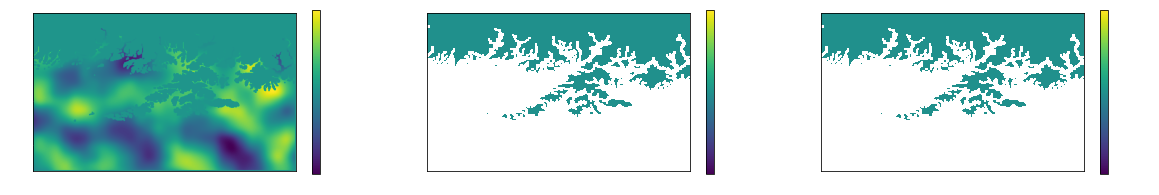

In [64]:
fig, axs = plt.subplots(1,3, figsize=(20,10))
im = axs[0].imshow((eta_pert.data.get()))
plt.colorbar(im, ax=axs[0], shrink=0.3)
im = axs[1].imshow((hu_pert.data.get()))
plt.colorbar(im, ax=axs[1], shrink=0.3)
im = axs[2].imshow((hv_pert.data.get()))
plt.colorbar(im, ax=axs[2], shrink=0.3)

In [65]:
stream

Bathymetry

In [66]:
from gpuocean.utils import OceanographicUtilities
_, _, fine_H = OceanographicUtilities.rescaleIntersections(sim.downloadBathymetry()[0], fine_nx+5, fine_ny+5)

In [67]:
from gpuocean.utils import Common
fine_bathymetry = Common.Bathymetry(gpu_ctx, sim.gpu_stream, fine_nx, fine_ny, 2, 2, fine_H, sim.boundary_conditions)

In [68]:
Bm = fine_bathymetry.Bm.download(sim.gpu_stream)
Bm = np.ma.array(Bm, mask = (Bm > 1e10))

In [69]:
eta_pert, hu_pert, hv_pert = 3*[Common.CUDAArray2D(sim.gpu_stream, fine_nx, fine_ny, 2,2, np.ma.array(np.zeros((fine_ny+4, fine_nx+4), dtype=np.float32), mask=Bm.mask))]

In [70]:
_, _, fine_f = OceanographicUtilities.rescaleMidpoints(NetCDFInitialization.get_texture(sim, "coriolis_f_tex"), fine_nx+4, fine_ny+4)

In [71]:
ocean_state_noise.perturbOceanState(eta_pert, hu_pert, hv_pert, fine_sim.bathymetry.Bi, fine_sim.f, ghost_cells_x=2, ghost_cells_y=2)

In [72]:
pert_eta = eta_pert.download(sim.gpu_stream)
pert_hu = hu_pert.download(sim.gpu_stream)
pert_hv = hv_pert.download(sim.gpu_stream)